In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def cv_show(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
def cv2_show(img,name):
    cv2.imshow(name,img)
    cv2.waitKey()
    cv2.destroyAllWindows()

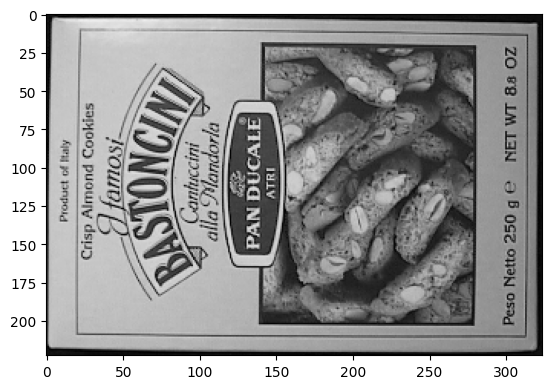

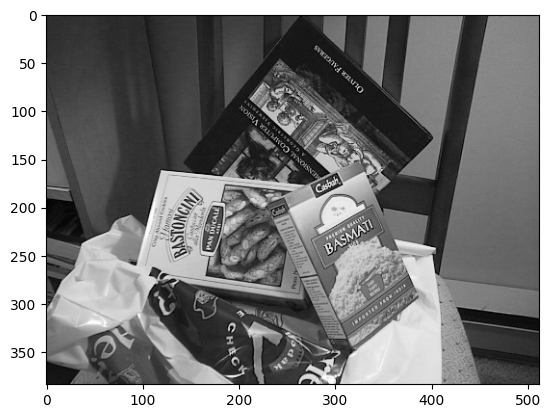

In [2]:
img1 = cv2.imread('01_Picture/19_Box.png',0)
img2 = cv2.imread('01_Picture/20_Box_in_scene.png',0)

cv_show(img1)
cv_show(img2)

[ WARN:0@1886.121] global shadow_sift.hpp:15 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


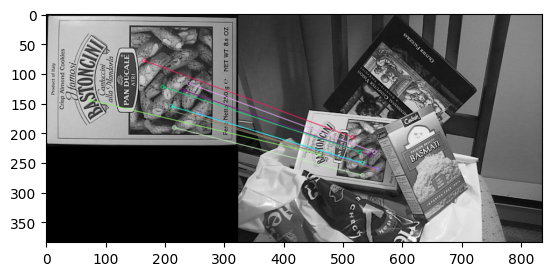

In [3]:
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# crossCheck 表示两个特征点要互相匹配，例如A中的第i个特征点与B中的第j个特征点最近的，并且B中的第j个特征点到A中的第i个特征点也是最近的。
# 将两幅图像的特征点、特征向量算出来，用欧氏距离取比较特征向量相似性，一般情况下默认用的是归一化后的欧氏距离去做，为了使得结果更均衡些。
# 如果不用sift特征计算方法去做，而是用其他特征计算方法需要考虑不同的匹配方式。
bf = cv2.BFMatcher(crossCheck = True)

# 1对1的匹配
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)
# 画前10个点
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=2)
cv_show(img3)


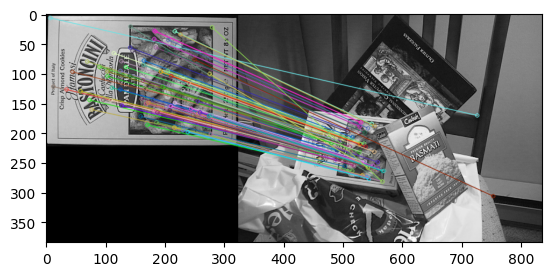

In [5]:
# k对最佳匹配
#bf = cv2.BFMatcher()
bf = cv2.FlannBasedMatcher()
matches = bf.knnMatch(des1, des2, k=2)

good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append([m])

img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None, flags=2)
cv_show(img3)

In [7]:
class Stitcher:
    def stitch(self, images, ratio=0.75, reprojThresh=4.0, showMatches=False):
        (imageB, imageA) = images
        (kpsA, featuresA) = self.detectAndDescribe(imageA)
        (kpsB, featuresB) = self.detectAndDescribe(imageB)

        # 匹配两站图片的所有特征点，返回匹配结果
        M = self.matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh)

        # 如果返回结果为空，没有匹配成功的特征点，退出算法
        if M is None:
            return None
        
        # 否则，提取匹配结果
        # H是3x3视角变换矩阵
        (matches, H, status) = M
        # 将图片A进行视角变换，result是变换后的图片
        result = cv2.warpPerspective(imageA, H, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
        cv_show(result)
        # 将图片B传入result图片最左端
        result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB
        cv_show(result)
        # 检测是否需要显示图片匹配
        if showMatches:
            # 生成匹配图片
            vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches, status)
            # 返回结果
            return (result, vis)
        
        # 返回匹配结果
        return result
    
    def detectAndDescribe(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        descriptor = cv2.xfeatures2d.SIFT_create()
        (kps, features) = descriptor.detectAndCompute(image, None)
        kps = np.float32([kp.pt for kp in kps])
        return (kps, features)
    
    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
        matcher = cv2.BFMatcher()

        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)

        matches = []
        for m in rawMatches:
            # 当最近距离和次近距离的比值小于ratio值时，保留此匹配对
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                # 存储两个点在featuresA，featuresB中的索引值
                matches.append((m[0].trainIdx, m[0].queryIdx))

        # 当筛选后的匹配对大于4时，计算视角变换矩阵
        if len(matches) > 4:
            # 获取匹配对的点坐标
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])
        
            # 计算视角变换矩阵
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)

            # 返回结果
            return (matches, H, status)

        # 如果匹配对小于4是，返回None
        return None

    def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
        (hA, wA) = imageA.shape[:2]
        (hB, wB) = imageB.shape[:2]    
        vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
        vis[0:hA, 0:wA] = imageA
        vis[0:hB, wA:] = imageB

        # 联合遍历，画出匹配对
        for ((trainIdx, queryIdx), s) in zip(matches, status):
            # 当点对匹配成功时，画到可视化图上
            if s == 1:
                ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
                ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
                cv2.line(vis, ptA, ptB, (0, 255, 0), 1)
        
        # 返回可视化结果
        return vis

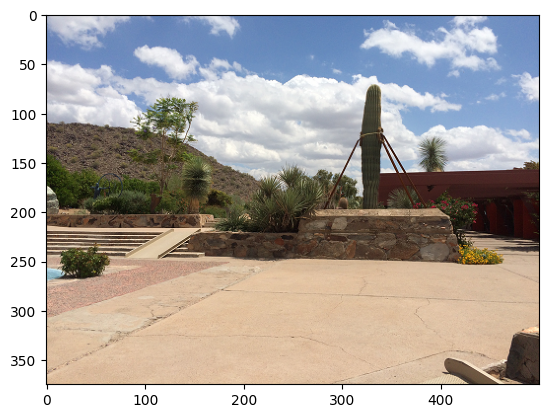

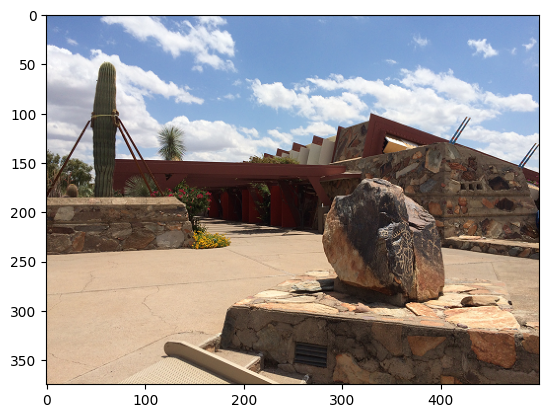

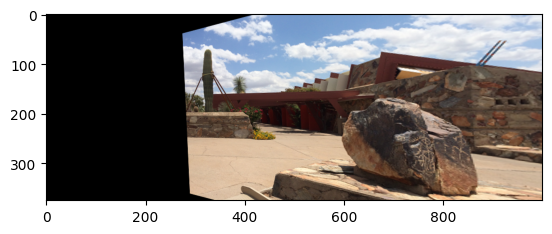

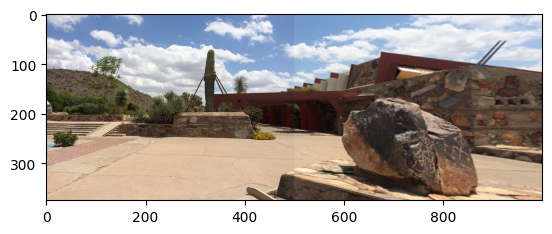

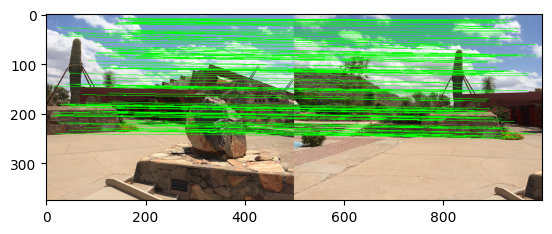

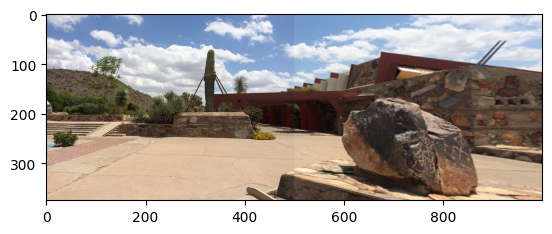

In [8]:
# 读取拼接图片
imageA = cv2.imread("01_Picture/21_Left_01.png")
imageB = cv2.imread("01_Picture/22_Right_01.png")
cv_show(imageA)
cv_show(imageB)

stitcher = Stitcher()
(result, vis) = stitcher.stitch([imageA, imageB], showMatches=True)

cv_show(vis)
cv_show(result)